# Ariline Customer Satisfaction (Mini Lab: DS7331)

SMU Student collaboration:
1. Renfeng Wang
2. Alexander Sepenu
3. Zachary Zaiken
4. Venkata 'MG' Vanga
---------------------------------------------


In continuation of the discussion from Lab 1, we continue with the Airline customer satisfaction data set for this mini lab to focus on Linear Regression and Support Vector Machines (SVM) in following discussion:

## Import Data

The code below imports the flight satisfaction from our githubrepository that will be used for the Logistic regression and Support Machine Vectors Analysis.  In addition, the index column 'Unnamed' will be dropped and any rows with NULL records.  In the previous visualization analysis it was shown that NULL values account for less than .5% of the dataset, as such there is minimal risk in removing these when building models.

In [1]:
import pandas as pd
import numpy as np
# read in the csv file
airline_df = pd.read_csv('https://raw.githubusercontent.com/wangrenfeng0/Machine-Learning-I/main/airline_passenger_satisfaction.csv') 

if 'Unnamed: 0' in airline_df:
    del airline_df['Unnamed: 0']

airline_df = airline_df.dropna()

airline_df.head()

,Gender,customer_type,age,type_of_travel,customer_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,...,inflight_entertainment,onboard_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Transform and Cleanup Data

Based on the results from airline_df.head() and airline_df.info() there are some variables than need to transformed before we can perform logistic regression or SVM model.

In [2]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129487 non-null  object 
 1   customer_type                      129487 non-null  object 
 2   age                                129487 non-null  int64  
 3   type_of_travel                     129487 non-null  object 
 4   customer_class                     129487 non-null  object 
 5   flight_distance                    129487 non-null  int64  
 6   inflight_wifi_service              129487 non-null  int64  
 7   departure_arrival_time_convenient  129487 non-null  int64  
 8   ease_of_online_booking             129487 non-null  int64  
 9   gate_location                      129487 non-null  int64  
 10  food_and_drink                     129487 non-null  int64  
 11  online_boarding                    1294

The code below shows the breakout of the categorical variables, the only non binary variable is customer class.  As such this variable will be split into seperate columns via OneHotEncoding.  The other binary variables (Gender, customer_type, type of travel, and satisfaction) will be converted to an integer.

In [3]:
airline_df[['Gender','customer_type','type_of_travel','customer_class','satisfaction']].describe()

,Gender,customer_type,type_of_travel,customer_class,satisfaction
count,129487,129487,129487,129487,129487
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,65703,105773,89445,61990,73225


A quick histogram of the continuous variables age, flight distance, departure_delay and arrival delay show how they are distributed and any skewness.  From this we can determine how to best provide integer substitutes for the variables.  Because the vast majority of records have no delay, delays will be cut into 3 groups: 0 min delay, delay between 1-500 mins, 500 mins+

Age and flight distance appear to be much more normally distributed than flight delay, as such they will be cut into 3 ordinal rankings.

array([<AxesSubplot:title={'center':'age'}>,
       <AxesSubplot:title={'center':'flight_distance'}>,
       <AxesSubplot:title={'center':'departure_delay_in_minutes'}>,
       <AxesSubplot:title={'center':'arrival_delay_in_minutes'}>],
      dtype=object)

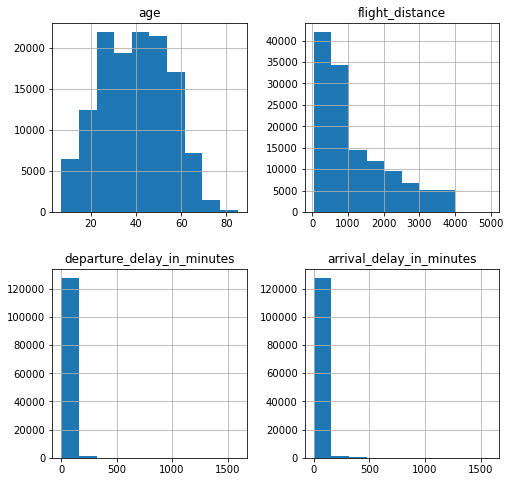

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(2,2,figsize=(8, 8))
airline_df[['age','flight_distance','departure_delay_in_minutes','arrival_delay_in_minutes']].hist(ax=axis)

The code below transforms the categorical and continuous variables via one hot encoding, pandas cut and pandas dummies.  The original variables are then removed only leaving the newly transformed variables.

In [5]:
Satisfaction ={'neutral or dissatisfied':0,'satisfied':1}
airline_df.satisfaction = [Satisfaction[item] for item in airline_df.satisfaction]

airline_df['flight_range'] = pd.cut(airline_df.flight_distance,[0,750,2000,10000],3,labels=[0,1,2])
airline_df.flight_range = airline_df.flight_range.astype(int)

airline_df['departure_delay_range'] = pd.cut(airline_df.departure_delay_in_minutes,[-1,30,90,1600],3,labels=[0,1,2])
airline_df.departure_delay_range = airline_df.departure_delay_range.astype(int)

airline_df['arrival_delay_range'] = pd.cut(airline_df.arrival_delay_in_minutes,[-1,30,90,1600],3,labels=[0,1,2])
airline_df.arrival_delay_range = airline_df.arrival_delay_range.astype(int)

airline_df['age_range'] = pd.cut(airline_df.age,[0,16,65,120],3,labels=[0,1,2])
airline_df.age_range = airline_df.age_range.astype(int)

X = airline_df.drop('satisfaction', axis=1).copy()


y = airline_df['satisfaction'].copy()

    
X = pd.get_dummies(X, columns=['Gender', 'customer_type','type_of_travel','customer_class',
                                       'flight_range','departure_delay_range','arrival_delay_range',
                                       'age_range'])

if 'Gender' in X:
    del X['Gender'] 
    
if 'customer_type' in X:    
    del X['customer_type'] 

if 'age' in X:    
    del X['age'] 
    
if 'type_of_travel' in X:    
    del X['type_of_travel'] 
    
if 'customer_class' in X:    
    del X['customer_class'] 
    
if 'flight_distance' in X:    
    del X['flight_distance'] 

if 'departure_delay_in_minutes' in X:    
    del X['departure_delay_in_minutes'] 
    
if 'arrival_delay_in_minutes' in X:    
    del X['arrival_delay_in_minutes'] 

airline_df_dummy = pd.concat((X,y),axis=1)
X.head()


,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,onboard_service,leg_room_service,...,flight_range_2,departure_delay_range_0,departure_delay_range_1,departure_delay_range_2,arrival_delay_range_0,arrival_delay_range_1,arrival_delay_range_2,age_range_0,age_range_1,age_range_2
0,3,4,3,1,5,3,5,5,4,3,...,0,1,0,0,1,0,0,1,0,0
1,3,2,3,3,1,3,1,1,1,5,...,0,1,0,0,1,0,0,0,1,0
2,2,2,2,2,5,5,5,5,4,3,...,0,1,0,0,1,0,0,0,1,0
3,2,5,5,5,2,2,2,2,2,5,...,0,1,0,0,1,0,0,0,1,0
4,3,3,3,3,4,5,5,3,3,4,...,0,1,0,0,1,0,0,0,1,0


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 129879
Data columns (total 35 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   inflight_wifi_service              129487 non-null  int64
 1   departure_arrival_time_convenient  129487 non-null  int64
 2   ease_of_online_booking             129487 non-null  int64
 3   gate_location                      129487 non-null  int64
 4   food_and_drink                     129487 non-null  int64
 5   online_boarding                    129487 non-null  int64
 6   seat_comfort                       129487 non-null  int64
 7   inflight_entertainment             129487 non-null  int64
 8   onboard_service                    129487 non-null  int64
 9   leg_room_service                   129487 non-null  int64
 10  baggage_handling                   129487 non-null  int64
 11  checkin_service                    129487 non-null  int64
 12  in

In [7]:
X = X.values
y= y.values

# 1. Create Models

The next set of code will focus on model building.  Prior to building or fitting any model. A cross validation object must be setup to assess the accuracy of the model.  In this case, using ShuffleSplit from sklearn module, we are able to create a 10 fold 80/20 test train split cross validation object.  In addition the random_state has been set to 5, this will allow is to test multiple models or multiple iterations of the same model witht he same 10 random 80/20 test train splits.  This ensures that any differing in model accuracy is not due to randomness of using different training and test sets.

In [8]:
from sklearn.model_selection import ShuffleSplit
 
num_cv_iterations = 10
num_instances = len(y)
cv = ShuffleSplit(n_splits=num_cv_iterations, test_size  = 0.2, random_state=5)
                         
print(cv)

ShuffleSplit(n_splits=10, random_state=5, test_size=0.2, train_size=None)


The following functions will allow us to easily test and report the accuracy, precision and recall of 10 test and train splits from the CV object.  The end result will show a dataframe with the individual results from each set as well as the average of all 10.

In [9]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X, y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(y,predictions)
    confMat = confusion_matrix(y,predictions)
    acc = accuracy_score(y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

## Logistic Regression Model

The code below fits a logistic regression model from all the finalized and transformed coefficients in the airline satisfaction dataset to predict flight satisfaction.  The model used a penalty value of "L1" for lasso regression.  This almost works like feature selection as the less important coefficients will be shrunk to 0.  The C-value is set to .05, which is lower than the default value of 1, this model will have stronger regularization.  Solver is set to default of ‘liblinear’.

The for loop in this code will build a logistic model on the training set and test the accuracy, specificity and sensitivity against the training set for all 10 of the cross-validation objects.  For each iteration a confusion matrix and the results of these 3 metrics are shown.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 
std_scl = StandardScaler()

piped_object = Pipeline([('scale', std_scl),  
                         ('logit_model', lr_clf)]) 

weights = []

for iter_num, (train_indices, test_indices) in enumerate(cv.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  
    y_hat = piped_object.predict(X[test_indices]) 
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    acc = mt.accuracy_score(y[test_indices],y_hat)
    
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    
    tn, fp, fn, tp = conf.ravel()
    
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    
    print("\n====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)
    print("accuracy", acc )
    print('specificity', specificity)
    print('sensitivity', sensitivity, '\n')
    
weights = np.array(weights)

w = list(weights[0])

i=1

for coef, name in zip(w,airline_df_dummy.columns):
    print([i], name, 'has weight of', coef)
    i = i + 1


====Iteration 0  ====
confusion matrix
 [[13029  1448]
 [ 1859  9562]]
accuracy 0.8723067418333462
specificity 0.8999792774746149
sensitivity 0.8372296646528326 


====Iteration 1  ====
confusion matrix
 [[13316  1421]
 [ 1803  9358]]
accuracy 0.8755116225191134
specificity 0.903576033113931
sensitivity 0.8384553355434101 


====Iteration 2  ====
confusion matrix
 [[13221  1436]
 [ 1820  9421]]
accuracy 0.8742760058691791
specificity 0.9020263355393328
sensitivity 0.8380926963793257 


====Iteration 3  ====
confusion matrix
 [[13212  1402]
 [ 1870  9414]]
accuracy 0.8736581975442119
specificity 0.9040645955932667
sensitivity 0.8342786246012053 


====Iteration 4  ====
confusion matrix
 [[13348  1384]
 [ 1907  9259]]
accuracy 0.8729245501583134
specificity 0.9060548465924518
sensitivity 0.8292136843990686 


====Iteration 5  ====
confusion matrix
 [[13133  1449]
 [ 1869  9447]]
accuracy 0.8718819986099313
specificity 0.9006309148264984
sensitivity 0.8348356309650053 


====Iteration 6 

While the logistic regression model yielded accurate results, the following code will allow us to cycle through many different parameter variations against the 10 fold cross validation object,  We will able to test two different penalty objects (L2 vs L1), differences in class weight, as well as different values in C.

In [11]:
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2','l1']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [5]
              ,'solver': ['liblinear']
              ,'max_iter':[100,500]
             }

from sklearn.model_selection import GridSearchCV

regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv 
                   , scoring='accuracy')

X_scaled = std_scl.transform(X)
regGridSearch.fit(X_scaled, y)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 560 out of 560 | elapsed:  2.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=5, test_size=0.2, train_size=None),
             estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', 'none'],
                         'max_iter': [100, 500], 'penalty': ['l2', 'l1'],
                         'random_state': [5], 'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

The results below show the most accurate model when testing all parameters.  In this case, using C=100, weight=balanced, penalty = L1 will create the most accurate results againsts our 10 fold cross validation object.

In [12]:
regGridSearch.best_estimator_

LogisticRegression(C=100, class_weight='balanced', penalty='l1', random_state=5,
                   solver='liblinear')

The code below utilizes the function we built prior to fitting the logistic regression model.  This allows us to plug in the results from the best fitted parametrs defined from the gridsearch function and see the resulting accruacy, precision and recall for each of the 10 cross folds.

In [13]:
classifierEst = regGridSearch.best_estimator_

EvaluateClassifierEstimator(classifierEst, X_scaled, y, cv)

The average accuracy for all cv folds is: 			 0.86808
The average precision for all cv folds is: 			 0.8411
The average recall for all cv folds is: 			 0.85756
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.866553,0.843053,0.856930
1,0.870801,0.843577,0.859600
2,0.867673,0.840390,0.858109
3,0.867866,0.842780,0.856523
4,0.868484,0.844338,0.852051
5,0.866553,0.839789,0.858342
6,0.868291,0.840014,0.857847
7,0.868484,0.837871,0.860315
8,0.869642,0.839788,0.863328
9,0.866438,0.839374,0.852564


## Support Vector Machines

The code below use a subset of 5000 rows out of the eligable ~130K to test which parameters for C and Gamma will create the most accurate SVC model.  With this resulta 10 fold cross validation will be done on a larger sample set 

In [14]:
svm_df = airline_df_dummy.sample(n = 5000).copy()
svm_y = svm_df['satisfaction'].copy()
svm_x = svm_df.loc[:, svm_df.columns != 'satisfaction'].copy()

svm_x = svm_x.values
svm_y= svm_y.values

In [15]:
from sklearn.model_selection import ShuffleSplit
 
svm_num_cv_iterations = 10
svm_num_instances = len(svm_y)
svm_cv = ShuffleSplit(n_splits=svm_num_cv_iterations, test_size  = 0.2, random_state=5)
                         
print(svm_cv)



ShuffleSplit(n_splits=10, random_state=5, test_size=0.2, train_size=None)


In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler



for train_indices, test_indices in svm_cv.split(svm_x,svm_y): 

    svm_x_train = svm_x[train_indices]
    svm_y_train = svm_y[train_indices]
    
    svm_x_test = svm_x[test_indices]
    svm_y_test = svm_y[test_indices]
    
svm_x_train_scaled = std_scl.transform(svm_x_train) 
svm_x_test_scaled = std_scl.transform(svm_x_test) 


In [17]:
parameters = [
  {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
    'kernel':['rbf'], 
    'degree':[3],  
  
  },
]


optimal_params = GridSearchCV(
        estimator=SVC(), 
        n_jobs=8,
        param_grid=parameters,
        cv=svm_cv,
        scoring='accuracy', 
        verbose=1
    )

optimal_params.fit(svm_x_train_scaled, svm_y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   47.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=5, test_size=0.2, train_size=None),
             estimator=SVC(), n_jobs=8,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'degree': [3],
                          'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=1)

The results below show that a C =1- and gamma = .01 will yield the most accurate results

In [18]:
print(optimal_params.best_estimator_)

SVC(C=10, gamma=0.01)


The code below creates a subset of 30000 rows out of the eligible ~130K.  Using the C and gamma from the optimal parameters above (10 and .01) A 10 fold cross validation will be created on the 30000 rows to test model accuracy.

In [19]:
svm_df2 = airline_df_dummy.sample(n = 30000).copy()
svm_y2 = svm_df2['satisfaction'].copy()
svm_x2 = svm_df2.loc[:, svm_df2.columns != 'satisfaction'].copy()

svm_x2 = svm_x2.values
svm_y2= svm_y2.values

In [20]:
from sklearn.model_selection import ShuffleSplit
 
svm_num_cv_iterations2 = 10
svm_num_instances2 = len(svm_y2)
svm_cv2 = ShuffleSplit(n_splits=svm_num_cv_iterations2, test_size  = 0.2, random_state=5)
                         
print(svm_cv2)

ShuffleSplit(n_splits=10, random_state=5, test_size=0.2, train_size=None)


In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler



for train_indices, test_indices in svm_cv2.split(svm_x2,svm_y2): 

    svm_x_train2 = svm_x2[train_indices]
    svm_y_train2 = svm_y2[train_indices]
    
    svm_x_test2 = svm_x2[test_indices]
    svm_y_test2 = svm_y2[test_indices]
    
svm_x_train_scaled2 = std_scl.transform(svm_x_train2) 
svm_x_test_scaled2 = std_scl.transform(svm_x_test2) 

In [22]:
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

svc_clf = SVC(C=10, kernel='rbf', degree=3, gamma=.01,random_state=5) 
std_scl = StandardScaler()

piped_object = Pipeline([('scale', std_scl),  
                         ('svc_model', svc_clf)]) 
#svc_weights = []

for iter_num, (train_indices, test_indices) in enumerate(svm_cv2.split(svm_x2,svm_y2)):
    piped_object.fit(svm_x2[train_indices],svm_y2[train_indices])  
    y_hat2 = piped_object.predict(svm_x2[test_indices]) 
    #svc_weights.append(piped_object.named_steps['svc_model'].coef_[0])
    acc = mt.accuracy_score(svm_y2[test_indices],y_hat2)
    
    conf = mt.confusion_matrix(svm_y2[test_indices],y_hat2)
    
    tn, fp, fn, tp = conf.ravel()
    
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    
    print("\n====Iteration",iter_num," ====")
    print("confusion matrix\n",conf)
    print("accuracy", acc )
    print('specificity', specificity)
    print('sensitivity', sensitivity, '\n')
    
print('Support Vector:', svc_clf.support_vectors_.shape, '\n')
print('Support:', svc_clf.n_support_ )
    


====Iteration 0  ====
confusion matrix
 [[3212  143]
 [ 214 2431]]
accuracy 0.9405
specificity 0.9573770491803278
sensitivity 0.9190926275992438 


====Iteration 1  ====
confusion matrix
 [[3246  145]
 [ 204 2405]]
accuracy 0.9418333333333333
specificity 0.9572397522854615
sensitivity 0.9218091222690686 


====Iteration 2  ====
confusion matrix
 [[3235  137]
 [ 222 2406]]
accuracy 0.9401666666666667
specificity 0.9593712930011863
sensitivity 0.9155251141552512 


====Iteration 3  ====
confusion matrix
 [[3250  131]
 [ 235 2384]]
accuracy 0.939
specificity 0.961254066844129
sensitivity 0.9102710958381062 


====Iteration 4  ====
confusion matrix
 [[3213  131]
 [ 211 2445]]
accuracy 0.943
specificity 0.9608253588516746
sensitivity 0.9205572289156626 


====Iteration 5  ====
confusion matrix
 [[3154  125]
 [ 221 2500]]
accuracy 0.9423333333333334
specificity 0.9618786215309546
sensitivity 0.9187798603454612 


====Iteration 6  ====
confusion matrix
 [[3248  143]
 [ 219 2390]]
accuracy 0.

# 2. Model Advantages

Based on overall accuracy, sensitivity and specificity it appears the SVM model is superior to logistic regression (87% vs 94%).  Although there is a tradeoff in training time and efficiency.  Running the grid search, we had to limit the SVC total sample to only 5000 records of the ~130K.  Anything more than 5000 rows puts too much strain on the computer and is not able to run in a timely manner.  In addition, for the 10-fold cross validation, the overall sample was limited to 30,000 rows before a training and test set split.  Same reason as the grid search, anything more requires too much computational power and times out the machine.  

# 3. Interpret Feature Importance

The graph below shows the coefficients for each variable in the logistic regression model.  Since all the variables have been scaled, the coefficients can be used to determine importance of each feature.  From the graph it appears that online_boarding, type_of_travel (Personal_travel, business_travel), customer_type (loyal & disloyal) and inflight_wifi_service appear to be the most influential.  In addition, a data frame is displayed under this graph sorted by absolute value of the coefficient to further help visualize and understand feature important to this model.

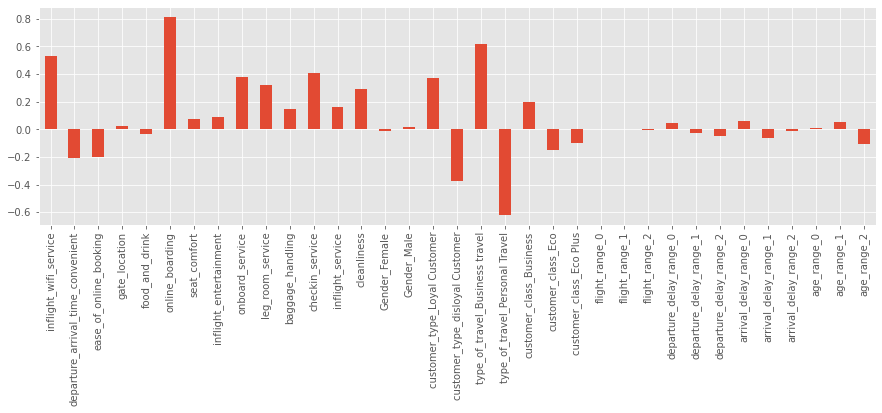

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(15,4))

airline_df_dummy1 = airline_df_dummy.drop('satisfaction', axis=1)

wgts = pd.Series(lr_clf.coef_[0],airline_df_dummy1.columns)
wgts.plot(kind='bar')
plt.show()



#Below code shows the same plot using plotly

#import plotly.graph_objects as go
##plotly.offline.init_notebook_mode()

#error_y=dict(type='data', array=np.std(weights,axis=0), visible=True)

#fig = go.Figure(data=go.Bar(
       # x=airline_df_dummy.columns,
       # y=np.mean(weights,axis=0),
       # error_y=error_y
       # ))
#
#fig.update_layout(xaxis_tickangle=90)

#fig.show()


#np.mean(weights,axis=0)
#airline_df_dummy.columns
#error_y

In [24]:
wgts = wgts.reset_index()
wgts[1]=wgts[0].abs()
wgts.columns
wgts= wgts.sort_values(by=1, ascending=False)
wgts[['index',0]]

,index,0
5,online_boarding,0.812940
18,type_of_travel_Business travel,0.616369
19,type_of_travel_Personal Travel,-0.616369
0,inflight_wifi_service,0.533745
11,checkin_service,0.408514
8,onboard_service,0.378486
16,customer_type_Loyal Customer,0.375303
17,customer_type_disloyal Customer,-0.375303
9,leg_room_service,0.319499
13,cleanliness,0.289703


# 4. Interpret Support Vectors

SVM is close together becasue the instances chosen are close to the support boundry. no feature importance for SVM.

In [25]:
airline_df_tested_on = airline_df_dummy.iloc[train_indices].copy() 

airline_df_support = airline_df_tested_on.iloc[svc_clf.support_,:].copy()

airline_df_support['satisfaction'] = y[svc_clf.support_] 
airline_df['satisfaction'] = y 
airline_df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4401 entries, 21828 to 7527
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   inflight_wifi_service              4401 non-null   int64
 1   departure_arrival_time_convenient  4401 non-null   int64
 2   ease_of_online_booking             4401 non-null   int64
 3   gate_location                      4401 non-null   int64
 4   food_and_drink                     4401 non-null   int64
 5   online_boarding                    4401 non-null   int64
 6   seat_comfort                       4401 non-null   int64
 7   inflight_entertainment             4401 non-null   int64
 8   onboard_service                    4401 non-null   int64
 9   leg_room_service                   4401 non-null   int64
 10  baggage_handling                   4401 non-null   int64
 11  checkin_service                    4401 non-null   int64
 12  inflight_service

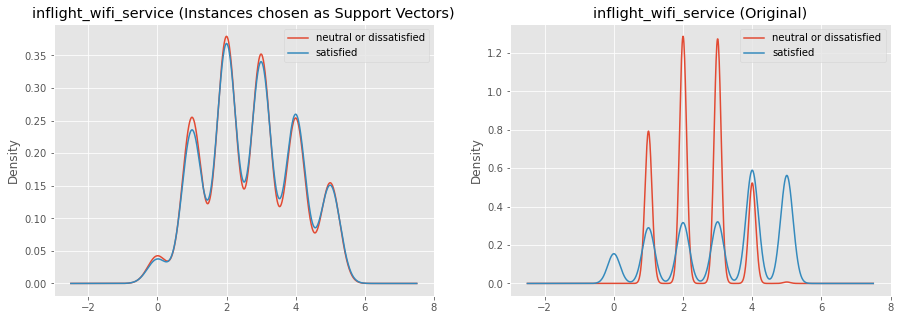

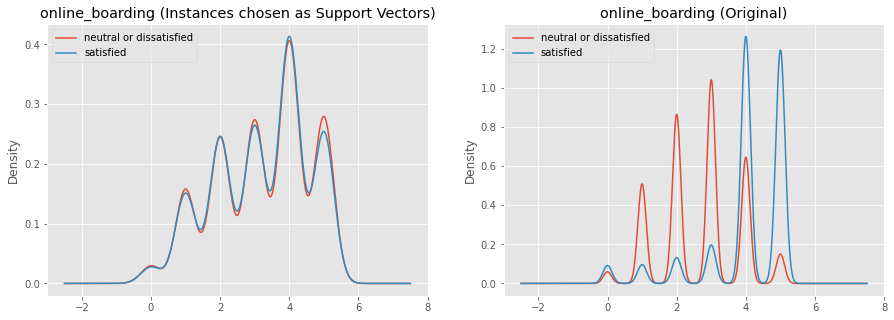

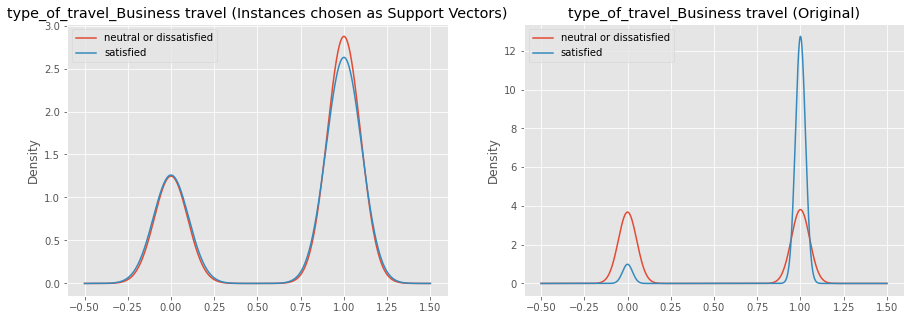

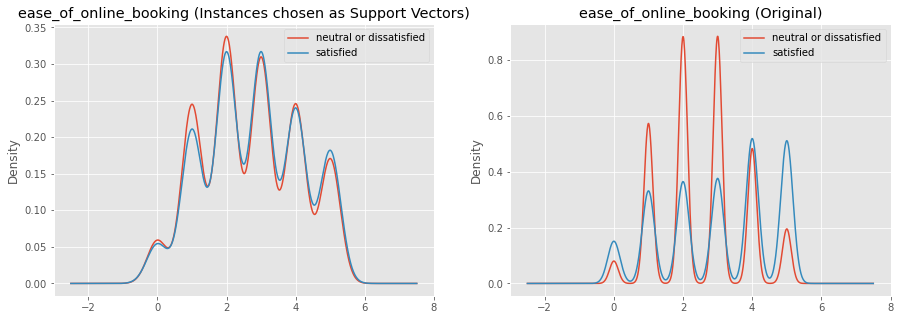

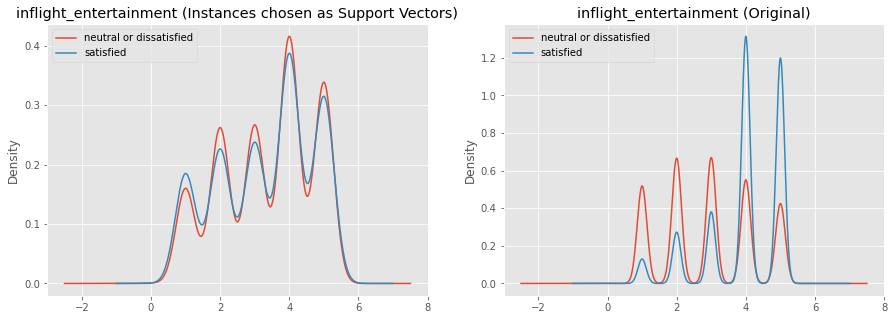

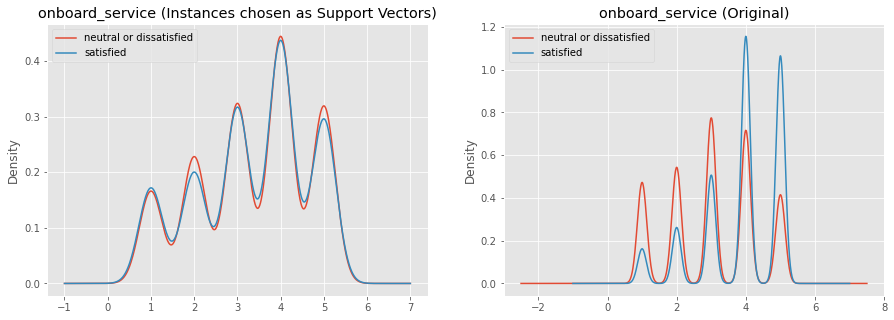

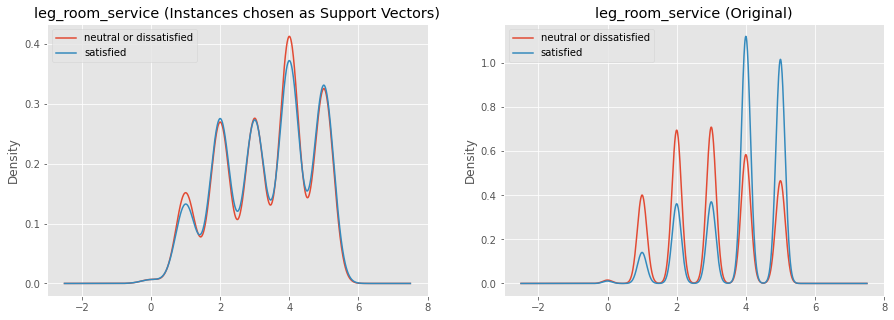

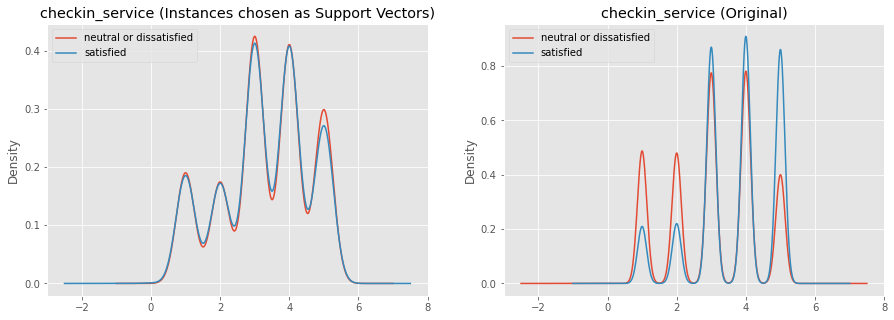

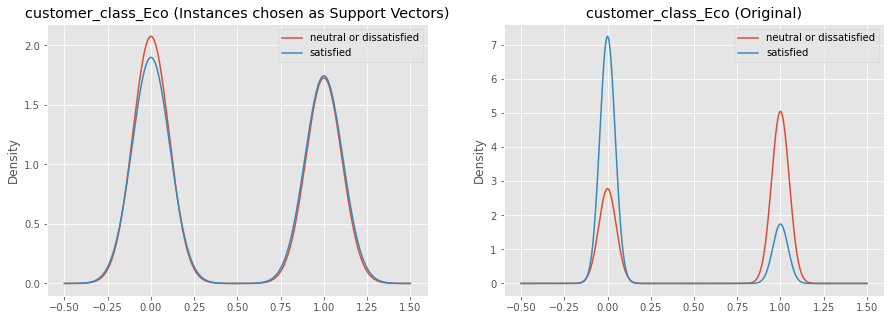

In [26]:
from pandas.plotting import boxplot
from matplotlib import pyplot as plt

airline_grouped_support = airline_df_support.groupby(['satisfaction'])
airline_grouped = airline_df_dummy.groupby(['satisfaction'])

# plot KDE of Different variables
vars_to_plot = ['inflight_wifi_service','online_boarding','type_of_travel_Business travel','ease_of_online_booking',
               'inflight_entertainment','onboard_service','leg_room_service','checkin_service','customer_class_Eco']

for v in vars_to_plot:
    plt.figure(figsize=(15,5))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = airline_grouped_support[v].plot.kde() 
    plt.legend(['neutral or dissatisfied','satisfied'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = airline_grouped[v].plot.kde() 
    plt.legend(['neutral or dissatisfied','satisfied'])
    plt.title(v+' (Original)')

plt.show()